# Ataques Adversariais: Comprometendo Sistemas Baseados em Machine Learning

In [1]:
!pip install tensorflow==2.12.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.10.5 requires jax>=0.5.1, but you have jax 0.4.38 which is incompatible.
google-genai 1.10.0 requires typin

## Importações

In [1]:
# Import libraries
import numpy as np
from PIL import Image, ImageOps  # Install pillow instead of PIL
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Import tensorflow and keras libraries
import tensorflow as tf
from keras.models import load_model  # TensorFlow is required for Keras to work

## Funções Úteis

In [2]:
# Preprocess image so that it can be inputted to MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Load and preprocess image
def loadAndPreprocessImage(image_path):
  image = Image.open(image_path)
  image = image.convert("RGB")
  image = preprocess(image)
  return image

# Print image and its class and score if they exist
def printImage(image, class_name=None, confidence_score=None, eps=None):
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  if((class_name == None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}'.format(eps))
  elif((class_name != None) and (eps == None)):
    plt.title('Classe: {} Confiança: {}'.format(class_name, confidence_score))
  elif((class_name != None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}\nClasse: {} Confiança: {}'.format(eps, class_name, confidence_score))
  plt.show()

# Classify sample using a pretrained model
def classifySample(image, pretrained_model):
  image_probs = pretrained_model.predict(image)
  index = np.argmax(image_probs)
  class_name = decode_predictions[index]
  confidence_score = image_probs[0][index]
  return image_probs, class_name, confidence_score

## Mostrando as imagens

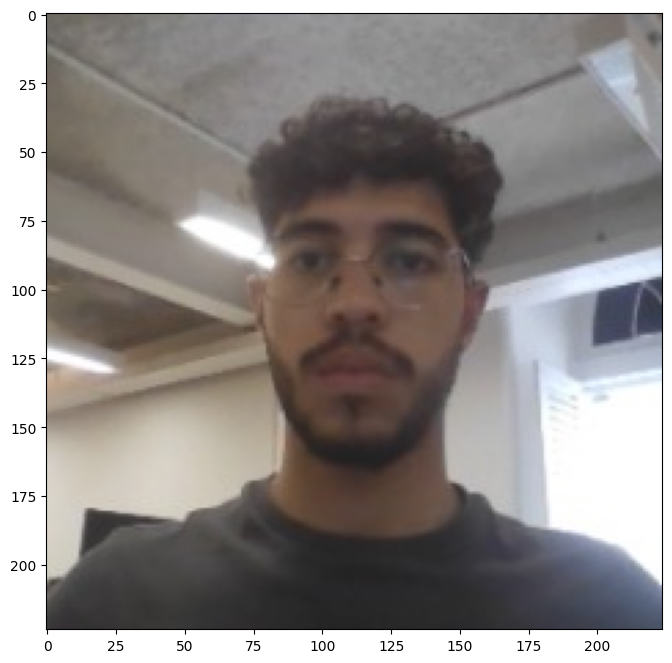

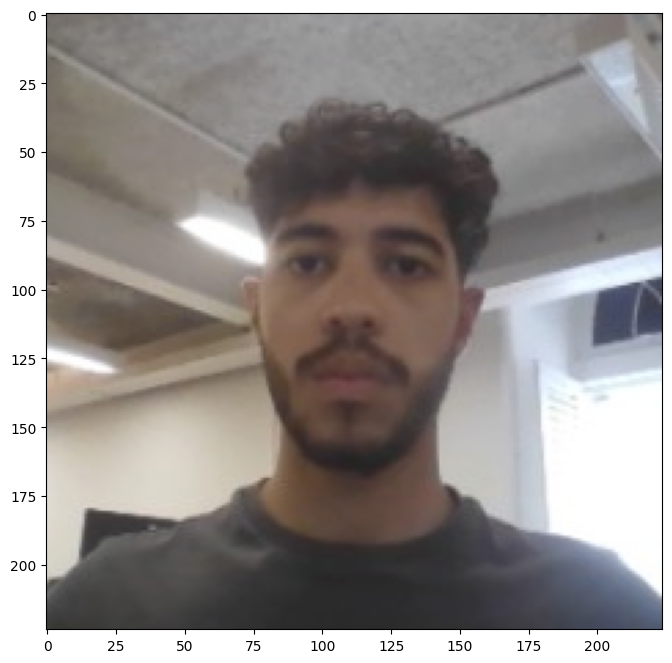

In [3]:
# Load and preprocess sample image
image1 = loadAndPreprocessImage('imagem01.jpg')
image2 = loadAndPreprocessImage('imagem02.jpg')
printImage(image1)
printImage(image2)

## Carregando o modelo

In [4]:
# Load pretrained classifier
pretrained_model = load_model("keras_model.h5", compile=False)
pretrained_model.trainable = False
decode_predictions = open("labels.txt", "r").readlines()

## Realizando a inferência

1/1 [==============================] - 1s 1s/step


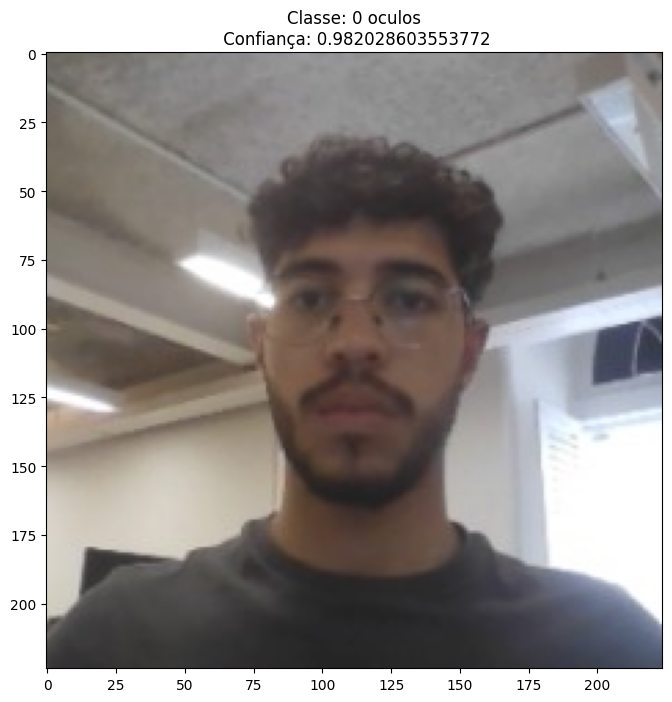

1/1 [==============================] - 0s 42ms/step


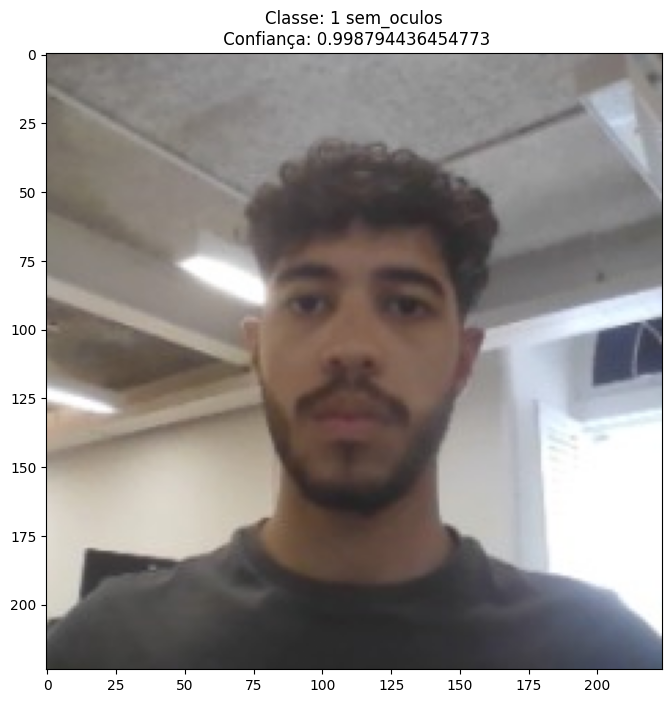

In [5]:
# Classify sample image and print classification result
image_probs, class_name, confidence_score = classifySample(image1, pretrained_model)
# print(image_probs)
printImage(image1, class_name, confidence_score)

image_probs, class_name, confidence_score = classifySample(image2, pretrained_model)
# print(image_probs)
printImage(image2, class_name, confidence_score)

# BlackBox - Adversarial Attacks

## Square Attack

O square attack é um ataque black-box, ou seja, não necessita de acesso à arquitetura, parâmetros e dados de treino para ser executado. O Square Attack precisa apenas de acesso ao score das classes calculado pelo classificador para produzir exemplos adversariais por meio de um processo iterativo.

 O ataque foi pensado para ser utilizado no cenário de redes neurais profundas que têm como entrada imagens, e este fato é importante pois explica o raciocínio por trás do ataque. As redes neurais convolucionais varrem uma imagem, a processando em pequenas janelas de formato quadrado, assim o Square Attack busca perturbar essas redes introduzindo perturbações em forma de quadrados de tamanho e intensidade variados.

Podemos descrever o funcionamento do ataque nos seguintes passos:

1. Gerar uma perturbação aleatória em forma de quadrado com uma localização e intensidade aleatória;
2. Aplicar esta perturbação à imagem;
3. Obter os scores da imagem perturbada;
4. Caso o score da classe correta diminua, manter essa perturbação, caso contrário descartar;
5. Repetir o processo até obter um exemplo adversarial ou atingir um número limite de iterações.

Como parâmetros do Square Attack, temos:

1. eps: Controlar a intensidade da perturbação;
2. initial_p: Controla o tamanho inicial do quadrado, sendo que o tamanho dos quadrados gerados é reduzido com o passar das iterações;
3. n_iters: Quantidade de chamadas ao modelo que serão executadas;
4. initialization: Se uma inicialização será aplicada à imagem.

Assim, alterando os parâmetros é possível obter um ataque que de maneira veloz gere perturbações adversariais bem perceptíveis, ou um ataque mais discreto que precisa de mais iterações para gerar perturbações.

### Classe que implementa o Square Attack.

In [6]:
# adaptado de https://github.com/max-andr/square-attack
# artigo: https://arxiv.org/abs/1912.00049

import numpy as np
from tqdm import tqdm

class SquareAttack:
  def __init__(self,eps,n_iters,initial_p,initialization):
    self.eps = eps
    self.n_iters = n_iters
    self.initial_p = initial_p
    self.initialization = initialization

  # Seleciona o tamanho do quadrado de acordo com a iteração atual
  def p_selection(self,p_init,it,n_iters):
    it = int(it / n_iters * 10000)
    if 10 < it <= 50:
        p = p_init / 2
    elif 50 < it <= 200:
        p = p_init / 4
    elif 200 < it <= 500:
        p = p_init / 8
    elif 500 < it <= 1000:
        p = p_init / 16
    elif 1000 < it <= 2000:
        p = p_init / 32
    elif 2000 < it <= 4000:
        p = p_init / 64
    elif 4000 < it <= 6000:
        p = p_init / 128
    elif 6000 < it <= 8000:
        p = p_init / 256
    elif 8000 < it <= 10000:
        p = p_init / 512
    else:
        p = p_init
    return p

  def apply(self,model,image,y):
    _,h,w,c = image.shape
    n_features = c*h*w

    min_val,max_val = -1,1
    preds = np.array(model.predict(image,verbose=0))[0]
    y_pred = preds.argmax()
    score = preds[y_pred]

    X = image
    if self.initialization:
      init_delta = np.random.choice([-self.eps,self.eps],size=[1,w,c])
      X_best = tf.clip_by_value(image+init_delta,-1,1)
      pert = X_best-image
    else:
      X_best = image
      pert = X_best-image

    preds = np.array(model.predict(X_best,verbose=0))[0]
    y_pred = preds.argmax()

    if y_pred != y:
      return 1,X_best,pert

    score = preds[y_pred]
    loss_min = score

    for i_iter in range(self.n_iters-1):
      to_fool = loss_min >= 0.5

      if to_fool:
        X_curr,X_best_curr = X,X_best
        loss_min_curr = loss_min
        delta = (X_best_curr-X_curr).numpy()
        p = self.p_selection(self.initial_p,i_iter,self.n_iters)
        s = int(round(np.sqrt(p*n_features/c)))
        s = min(max(s,1),h-1)

        # Escolhe um centro aleatório para o quadrado
        center_h = np.random.randint(0,max(h-s,1))
        center_w = np.random.randint(0,max(w-s,1))

        x_curr_window = X_curr[:,center_h:center_h+s,center_w:center_w+s,:]
        X_best_curr_window = X_best_curr[:,center_h:center_h+s,center_w:center_w+s,:]

        # Gera uma perturbação aleatória no quadrado
        delta[:,center_h:center_h+s,center_w:center_w+s,:] = np.random.choice([-self.eps,self.eps],size=[1,1,c])

        X_new = tf.clip_by_value(X_curr+delta,-1,1)

        preds = np.array(model.predict(X_new,verbose=0))[0]
        y_pred = preds.argmax()
        score = preds[y_pred]

        if y_pred != y:
          return i_iter,X_new, (pert+delta)

        if score < loss_min:
          loss_min = score
          X_best = X_new
          pert += delta
    return self.n_iters, X_best,pert

Vamos observar a relação entre imperceptibilidade e velocidade do ataque, para tanto vamos definir duas configurações de parâmetros diferentes. Uma vai produzir perturbações mais perceptíveis que enganam o classificador mais rapidamente. A outra irá produzir perturbações mais discretas que demoram mais para apresentar efeito.

Configuração Discreta
*   eps: 0.035
*   initial_p: 0.5
*   Inicialização: Falso

Configuração Rápida
*   eps: 0.06
*   initial_p: 0.7
*   Inicialização: Verdadeiro

### Square Attack - Configuração Discreta

#### Construindo a Exemplo Adversarial

In [7]:
# For reproductibility
np.random.seed(19)

# Craft adversarial sample
attack = SquareAttack(eps=0.035, n_iters=600, initial_p=0.5, initialization=False)
n_iters, perturbed_image, pert = attack.apply(pretrained_model, image1, 0)
print(f"Número de iterações necessárias: {n_iters}")

Número de iterações necessárias: 41


#### Realizando a classificação do exemplo adversarial

1/1 [==============================] - 0s 40ms/step


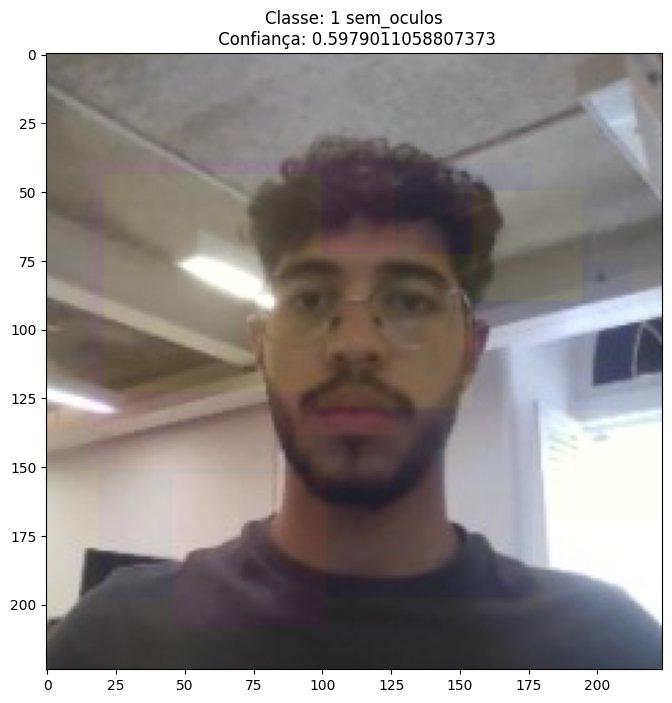

In [8]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(perturbed_image, pretrained_model)
printImage(perturbed_image, class_name, confidence_score)

#### Exibindo a perturbação adversarial

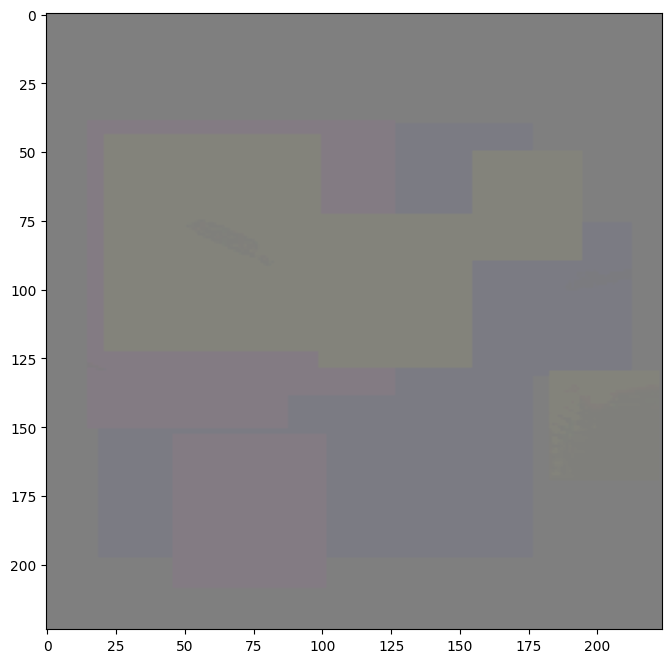

In [9]:
# # Get and print adversarial perturbation
# printImage(pert)  # perturbação total aplicada
printImage(perturbed_image - image1)  # perturbação com clip

### Square Attack - Configuração Rápida

#### Construindo o Exemplo Adversarial

In [10]:
np.random.seed(19)

# Craft adversarial sample
attack = SquareAttack(eps=0.06, n_iters=600, initial_p=0.7, initialization=True)
n_iters, perturbed_image, pert = attack.apply(pretrained_model, image1, 0)
print(f"Número de iterações necessárias: {n_iters}")

Número de iterações necessárias: 8


#### Realizando a classificação do exemlo adversarial

1/1 [==============================] - 0s 35ms/step


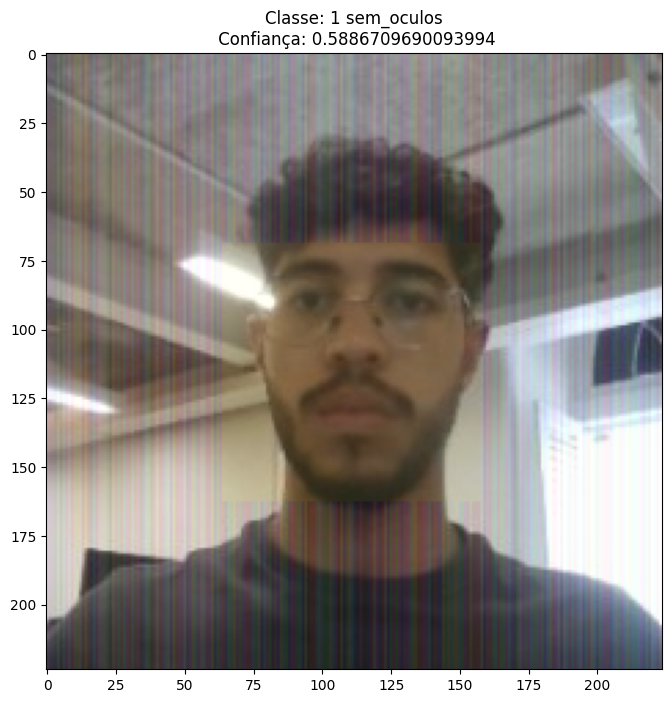

In [11]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(perturbed_image, pretrained_model)
printImage(perturbed_image, class_name, confidence_score)

#### Exibindo a perturbação adversarial

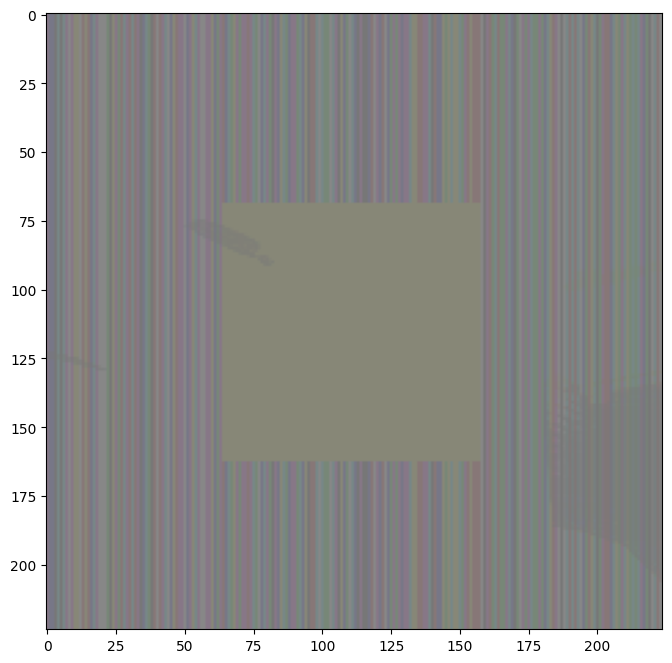

In [12]:
# # Get and print adversarial perturbation
# printImage(pert)  # perturbação total aplicada
printImage(perturbed_image - image1)  # perturbação com clip

## SimBA

O simBA (Simple Black Box Attack) também é um ataque iterativo baseado em score, com algumas diferenças em relação ao Square Attack. A intuição do simBA é baseada em obter ruídos retirados de direções ortnormais e então tentar adcionar esses ruídos à imagem. Um exemplos do que são essas direções ortonormais, é o espaço dos pixels da imagem, ou seja, cada perturbação seria aplicada à um único pixel.

A implementação adaptada abaixo leva em conta que para imagens de tamanho razoável, a alteração de um único pixel não é capaz de produzir variações grandes o suficiente no score. Assim a solução é utilizar blocos de pixels maiores como direção ortornomal.

Outro ponto, é que foi observado experimentalmente que perturbações em padrão de baixa frequência tem tendência adversarial em comparação à um padrão uniforme ou completamente aleatório. Portanto os padrões gerados são baseados em perturbações de baixa frequência.

Assim podemos descrever o algoritmo do simBA:

1. Retirar um vetor de uma base ortonormal;
2. Adcionar este vetor à imagem atual;
3. Caso o score da classe correta diminua, adotar esta perturbação;
4. Caso contrário, experimentar subtrair o vetor da imagem, caso o score diminua, adotar esta perturbação;
5. Repetir o processo até obter uma imagem adversarial ou atingir um limite de iterações.

Os parâmetros do simBA são:

1. epsilon: intensidade da perturbação.
2. block_size: tamanho do bloco a ser aplicado cada perturbação.
3. n_iters: número de iterações.

In [ ]:
pert = np.random.choice(np.arange(-2,2),4)
pert

array([ 0,  1, -2, -2])

In [ ]:
dale = np.reshape(pert, (2,2))

In [ ]:
from scipy.fftpack import dctn,idctn

idctn(dale, norm='ortho')

array([[-1.5, -0.5],
       [ 2.5, -0.5]])

In [ ]:
for i in range(min(n_dims,self.n_iters)):
    # o bloco de perturbação é gerado no domínio da transformada do cosseno e então levado para o domínio das imagens
    diff = np.zeros((block_size*block_size))
    diff = np.reshape(diff,(block_size,block_size))
    pert = np.random.choice(np.arange(-self.epsilon,self.epsilon),4)
    diff[:2,:2] = np.reshape(pert,(2,2))
    noise_block = idctn(diff,norm='ortho')

### Classe que implementa o SimBA

In [ ]:
# adaptado de https://github.com/cg563/simple-blackbox-attack/blob/master/simba.py
# artigo: https://arxiv.org/abs/1905.07121

from scipy.fftpack import dctn,idctn


class simBA:

  def __init__(self,epsilon,n_iters):
    self.epsilon = epsilon
    self.n_iters = n_iters

  def apply(self,image,y,model,block_size=8):
    _,h,w,c = image.shape

    # é necessário que as dimensões da imagem sejam múltiplas de block_size
    new_h = h+block_size-h%block_size
    new_w = w+block_size-w%block_size
    resized_x = np.zeros((1,new_h,new_w,c))
    resized_x[:,:h,:w,:] = image
    resized_x = tf.convert_to_tensor(resized_x)

    min_val, max_val = -1,1

    n_dims = int((new_h*new_w*c)/(block_size**2))

    perm = np.random.permutation(n_dims)

    preds = np.array(model.predict(image,verbose=0))[0]
    y_pred = preds.argmax()
    score = preds[y_pred]

    loss_min = score
    x_best = resized_x

    n_queries = 1
    iteration_index = 1

    for i in range(min(n_dims,self.n_iters)):
      # o bloco de perturbação é gerado no domínio da transformada do cosseno e então levado para o domínio das imagens
      diff = np.zeros((block_size*block_size))
      diff = np.reshape(diff,(block_size,block_size))
      pert = np.random.choice(np.arange(-self.epsilon,self.epsilon),4)
      diff[:2,:2] = np.reshape(pert,(2,2))
      noise_block = idctn(diff,norm='ortho')

      index = perm[i]
      channel_index = int(index//((new_h*new_w)/(block_size**2)))
      remaining_index = index - channel_index*((new_h*new_w)/block_size**2)
      row_index = int(remaining_index // (new_w/block_size))
      col_index = int((remaining_index-row_index*(new_w/block_size)))

      x_new = x_best.numpy()
      x_new[:,row_index*block_size:\
            (row_index+1)*block_size,col_index*block_size:\
            (col_index+1)*block_size,channel_index] \
            = \
     (x_new[:,row_index*block_size:\
            (row_index+1)*block_size,col_index*block_size:\
            (col_index+1)*block_size,channel_index]+noise_block).clip(min_val,max_val)

      x_new_cropped = x_new[:,:h,:w,:]

      preds = np.array(model.predict(x_new_cropped,verbose=0))[0]
      y_pred = preds.argmax()
      score = preds[y_pred]

      if y_pred != y:
        return n_queries,x_new_cropped

      n_queries += 1
      # caso a adição de ruído piore o score da classe
      if score < loss_min:
        x_best = tf.convert_to_tensor(x_new)
        loss_min = score
      else:
        if n_queries >= self.n_iters:
          break

        x_new = x_best.numpy()
        # caso contrário investigamos a subtração
        x_new[:,row_index*block_size:(row_index+1)*block_size,col_index*block_size:(col_index+1)*block_size,channel_index] = (x_new[:,row_index*block_size:(row_index+1)*block_size,col_index*block_size:(col_index+1)*block_size,channel_index]-noise_block).clip(min_val,max_val)

        x_new_cropped = x_new[:,:h,:w,:]
        preds = np.array(model.predict(x_new_cropped,verbose=0))[0]
        y_pred = preds.argmax()
        score = preds[y_pred]

        if y_pred != y:
          return n_queries,x_new_cropped

        n_queries += 1

        if score < loss_min:
          x_best = tf.convert_to_tensor(x_new)
          loss_min = score

      if n_queries >= self.n_iters:
        break
    return self.n_iters,x_best[:,:h,:w,:c]

### Criando o Exemplo Adversarial

In [ ]:
# inicializando o ataque
attack = simBA(1.6,600)

n_iters, perturbed_image = attack.apply(image1,0,pretrained_model,12)

print(f"Número de iterações necessárias:{n_iters}")

Número de iterações necessárias:128


### Realizando a classificação do exemplo adversarial

1/1 [==============================] - 0s 48ms/step


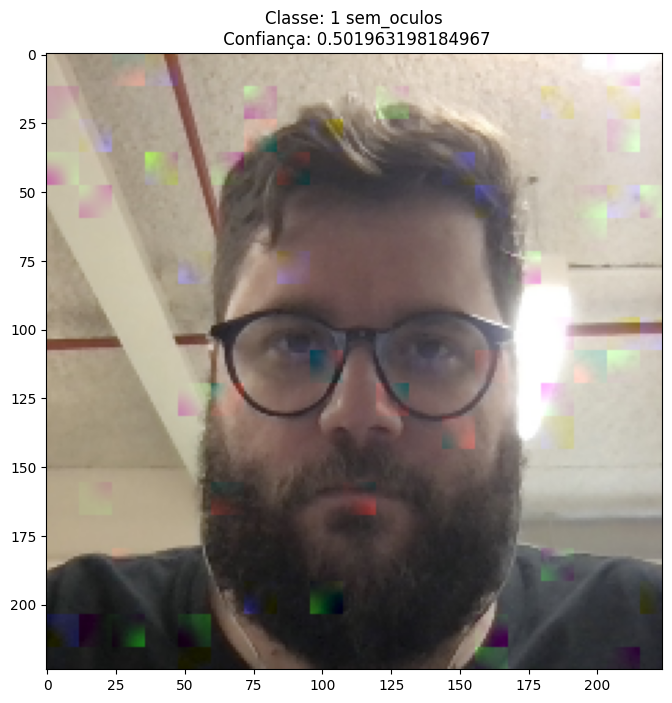

In [ ]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(perturbed_image, pretrained_model)
printImage(perturbed_image, class_name, confidence_score)

### Exibindo o ruído adicionado

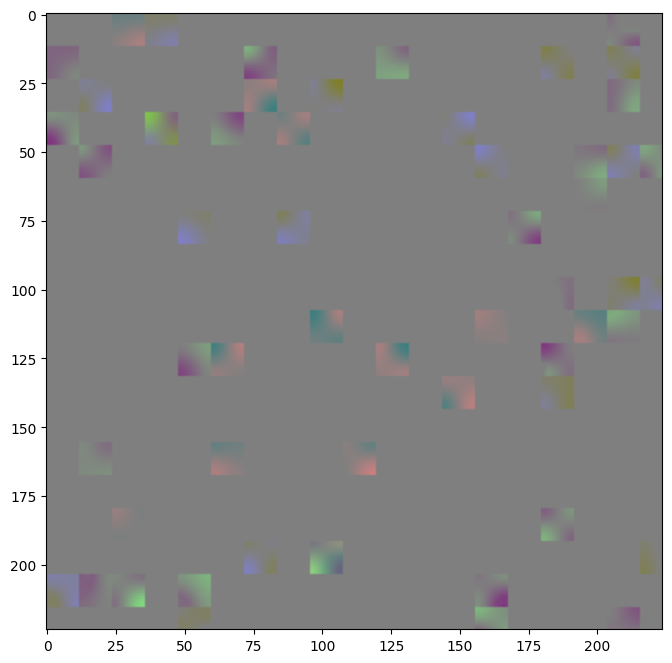

In [ ]:
# ruído adcionado
printImage(perturbed_image-image1)